<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_3/Supp_Fig_3abc/2_host_normalization_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Host data normalization and Leiden clustering

In [ ]:
!pip install -q anndata

In [ ]:
import anndata
import numpy as np
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import scanpy as sc
sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

Load filtered host data (see [this notebook](https://github.com/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Supp_Fig_3/Supp_Fig_3abc/1_host_QC.ipynb)):

In [ ]:
# Load filtered host data from Caltech Data
# !wget

In [ ]:
host_adata = anndata.read("host_QC.h5ad")
host_adata

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 237658 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species'
    var: 'gene_id', 'species'

___
# Add metadata

Add timepoints from SRR metadata:

In [ ]:
# Download library metadata
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/Supp_Fig_3/Supp_Fig_3abc/PRJNA665227_SraRunTable.txt

In [ ]:
srr_meta = pd.read_csv("PRJNA665227_SraRunTable.txt", sep=",")
# Only keep relevent data
srr_meta["mdck_spike_in"] = srr_meta["mdck_spike_in"].fillna(False).values
srr_meta = srr_meta[["Run", "donor_animal", "Experiment", "mdck_spike_in", "hours_post_innoculation", "day_post_infection"]]
srr_meta

,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
0,SRR12698499,NHP1,SRX9178097,False,4.0,NaN
1,SRR12698500,NHP1,SRX9178098,False,4.0,NaN
2,SRR12698501,NHP1,SRX9178099,False,4.0,NaN
3,SRR12698502,NHP1,SRX9178100,False,4.0,NaN
4,SRR12698503,NHP1,SRX9178101,False,4.0,NaN
...,...,...,...,...,...,...
101,SRR12698600,NHP10,SRX9178198,False,NaN,7.0
102,SRR12698601,NHP24,SRX9178199,False,NaN,6.0
103,SRR12698602,NHP24,SRX9178200,False,NaN,6.0
104,SRR12698603,NHP08,SRX9178201,False,NaN,-4.0


In [ ]:
host_adata.obs = (
        host_adata
        .obs.merge(srr_meta, left_on="srr", right_on="Run", how="left")
        .set_index("barcode", drop=False)
    )

host_adata.obs

/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['AAAAAAGGTTGT', 'AAAACCTACCAG', 'AAAACTCCATGT', 'AAAACTTCTCCC', 'AAAAGAAACTAT']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


,sample_barcode,barcode,srr,n_counts,n_genes,percent_mito,species,Run,donor_animal,Experiment,mdck_spike_in,hours_post_innoculation,day_post_infection
barcode,,,,,,,,,,,,,
AAAAAAGGTTGT,AAAAAAAAAAAAAAAA,AAAAAAGGTTGT,SRR12698516,681.0,438,0.041116,macaca_mulatta,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAACCTACCAG,AAAAAAAAAAAAAAAA,AAAACCTACCAG,SRR12698516,1409.0,647,0.013485,macaca_mulatta,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAACTCCATGT,AAAAAAAAAAAAAAAA,AAAACTCCATGT,SRR12698516,891.0,541,0.022447,macaca_mulatta,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAACTTCTCCC,AAAAAAAAAAAAAAAA,AAAACTTCTCCC,SRR12698516,1043.0,703,0.000000,macaca_mulatta,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
AAAAGAAACTAT,AAAAAAAAAAAAAAAA,AAAAGAAACTAT,SRR12698516,600.0,419,0.011667,macaca_mulatta,SRR12698516,NHP2,SRX9178114,False,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCCAGGGCT,AAAAAAAAAAAACGGC,TTTGCCAGGGCT,SRR12698550,1703.0,912,0.008808,macaca_mulatta,SRR12698550,NHP24,SRX9178148,True,NaN,6.0
TTTTAATCGGAT,AAAAAAAAAAAACGGC,TTTTAATCGGAT,SRR12698550,856.0,548,0.000000,canis_lupus_familiaris,SRR12698550,NHP24,SRX9178148,True,NaN,6.0
TTTTACACCTGT,AAAAAAAAAAAACGGC,TTTTACACCTGT,SRR12698550,736.0,471,0.000000,macaca_mulatta,SRR12698550,NHP24,SRX9178148,True,NaN,6.0


Drop cells that were identified as canis lupus but did not have a spike in:

In [ ]:
host_adata = host_adata[~((host_adata.obs["species"] == "canis_lupus_familiaris") & (host_adata.obs["mdck_spike_in"] == False)), :]
host_adata

View of AnnData object with n_obs × n_vars = 237351 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito', 'species', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection'
    var: 'gene_id', 'species'

Create clean dpi column:

In [ ]:
# Join day_post_infection and hours_post_innoculation columns
host_adata.obs["dpi"] = host_adata.obs["day_post_infection"].fillna(host_adata.obs["hours_post_innoculation"]).astype(int)

# Add h/d accession to denote hours/days
host_adata.obs["dpi_accessions"] = np.where(host_adata.obs["hours_post_innoculation"].isna(), "d", "h")
host_adata.obs["dpi_clean"] = host_adata.obs["dpi"].astype(str) + host_adata.obs["dpi_accessions"].astype(str)

/tmp/ipykernel_49019/1666420120.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  host_adata.obs["dpi"] = host_adata.obs["day_post_infection"].fillna(host_adata.obs["hours_post_innoculation"]).astype(int)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/laura/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


___
# Normalization and Leiden clustering

In [ ]:
# Split data into macaque and dog cells
macaca_adata = host_adata[host_adata.obs["species"] == "macaca_mulatta", :]
canis_adata = host_adata[host_adata.obs["species"] == "canis_lupus_familiaris", :]

In [ ]:
# Store raw counts before normalization
macaca_adata.raw = macaca_adata
canis_adata.raw = canis_adata

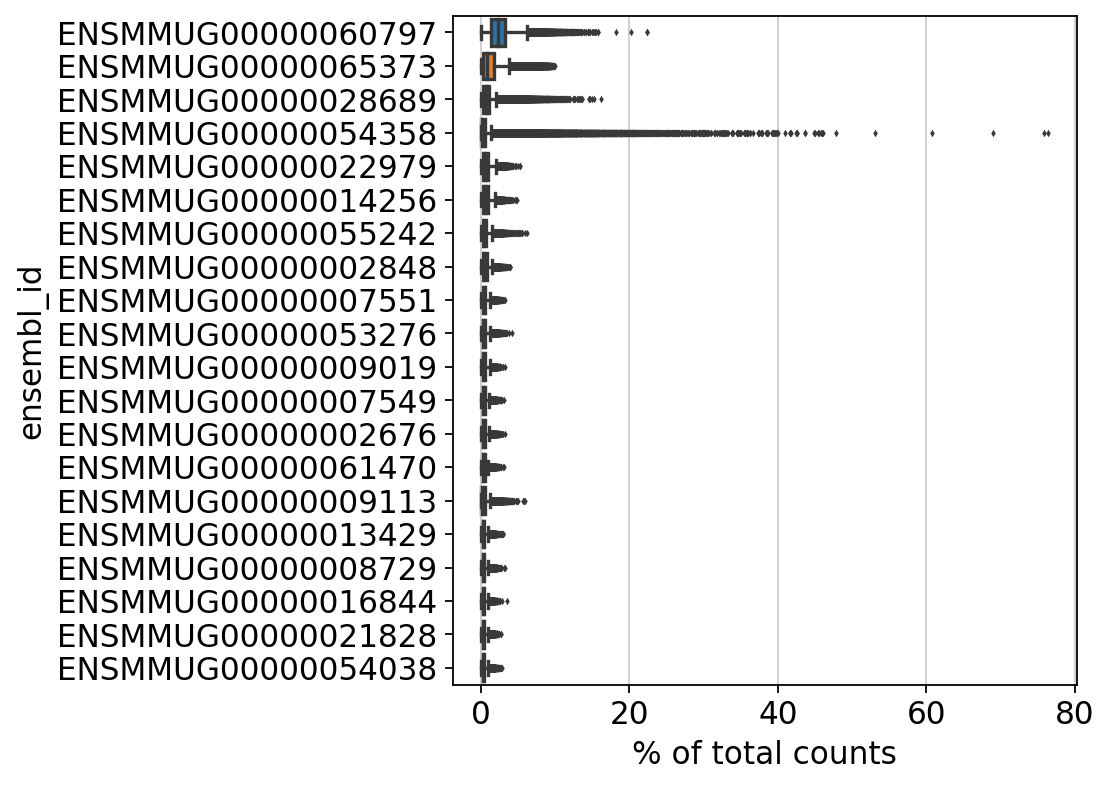

In [ ]:
sc.pl.highest_expr_genes(macaca_adata, n_top=20)

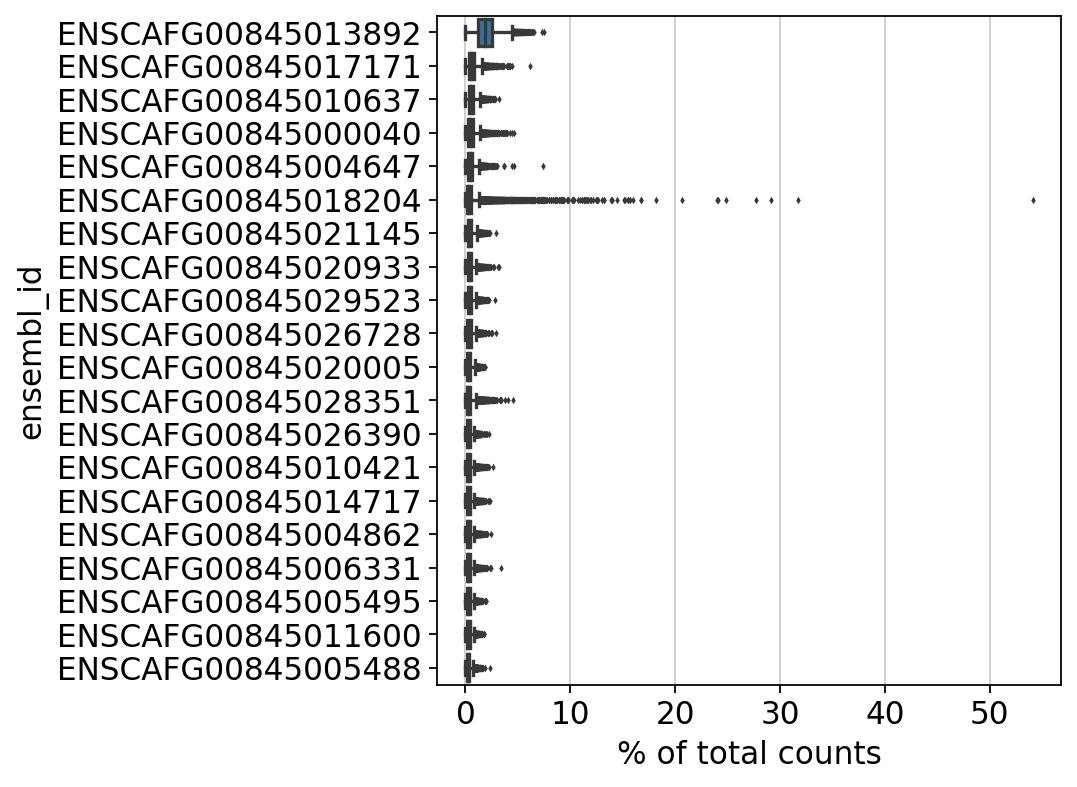

In [ ]:
sc.pl.highest_expr_genes(canis_adata, n_top=20)

Normalization:

In [ ]:
## log(CP10k+1)
# CP10k normalization
sc.pp.normalize_total(macaca_adata, target_sum=10**4)
sc.pp.normalize_total(canis_adata, target_sum=10**4)
# log(expression + 1)
sc.pp.log1p(macaca_adata) # log(expression + 1)
sc.pp.log1p(canis_adata) # log(expression + 1)

Highest expressed genes after normalization:

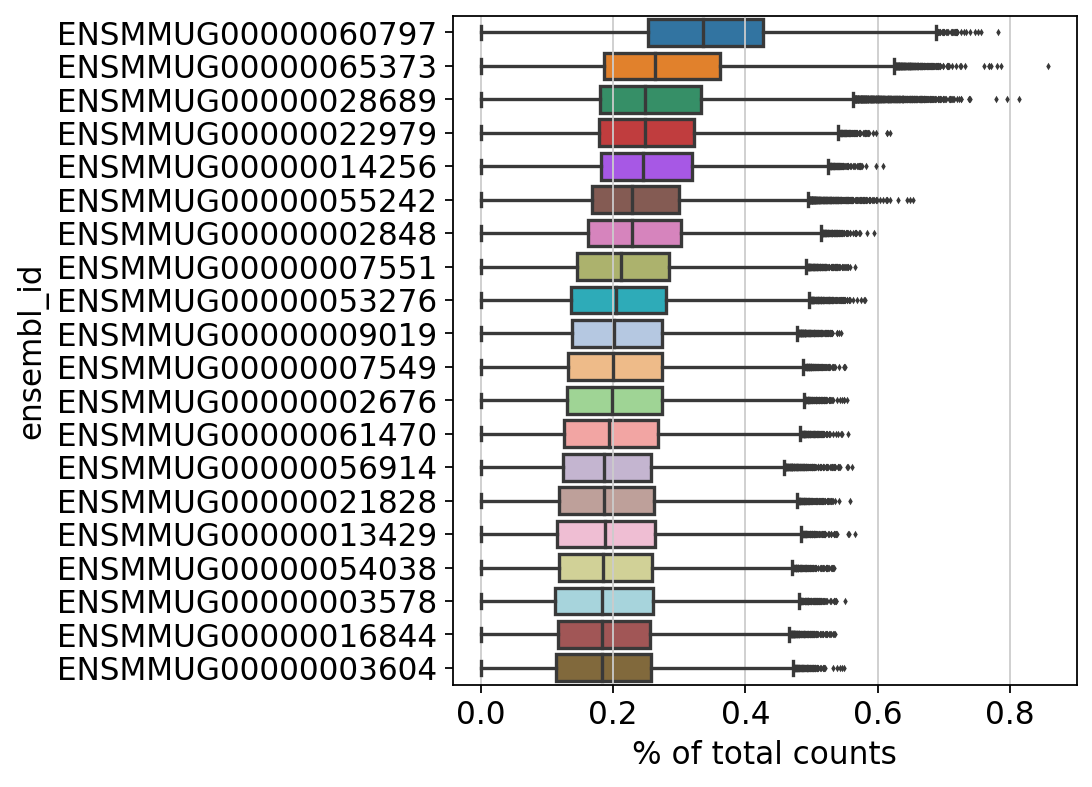

In [ ]:
sc.pl.highest_expr_genes(macaca_adata, n_top=20)

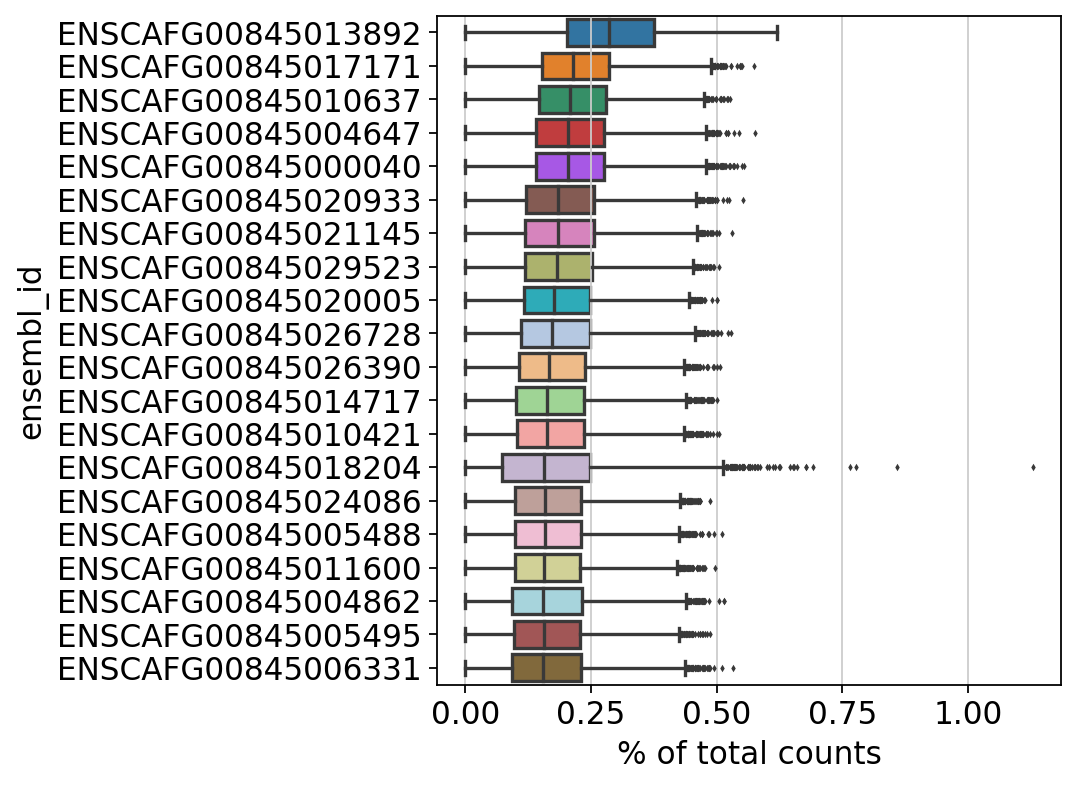

In [ ]:
sc.pl.highest_expr_genes(canis_adata, n_top=20)

Annotate highly variable genes:

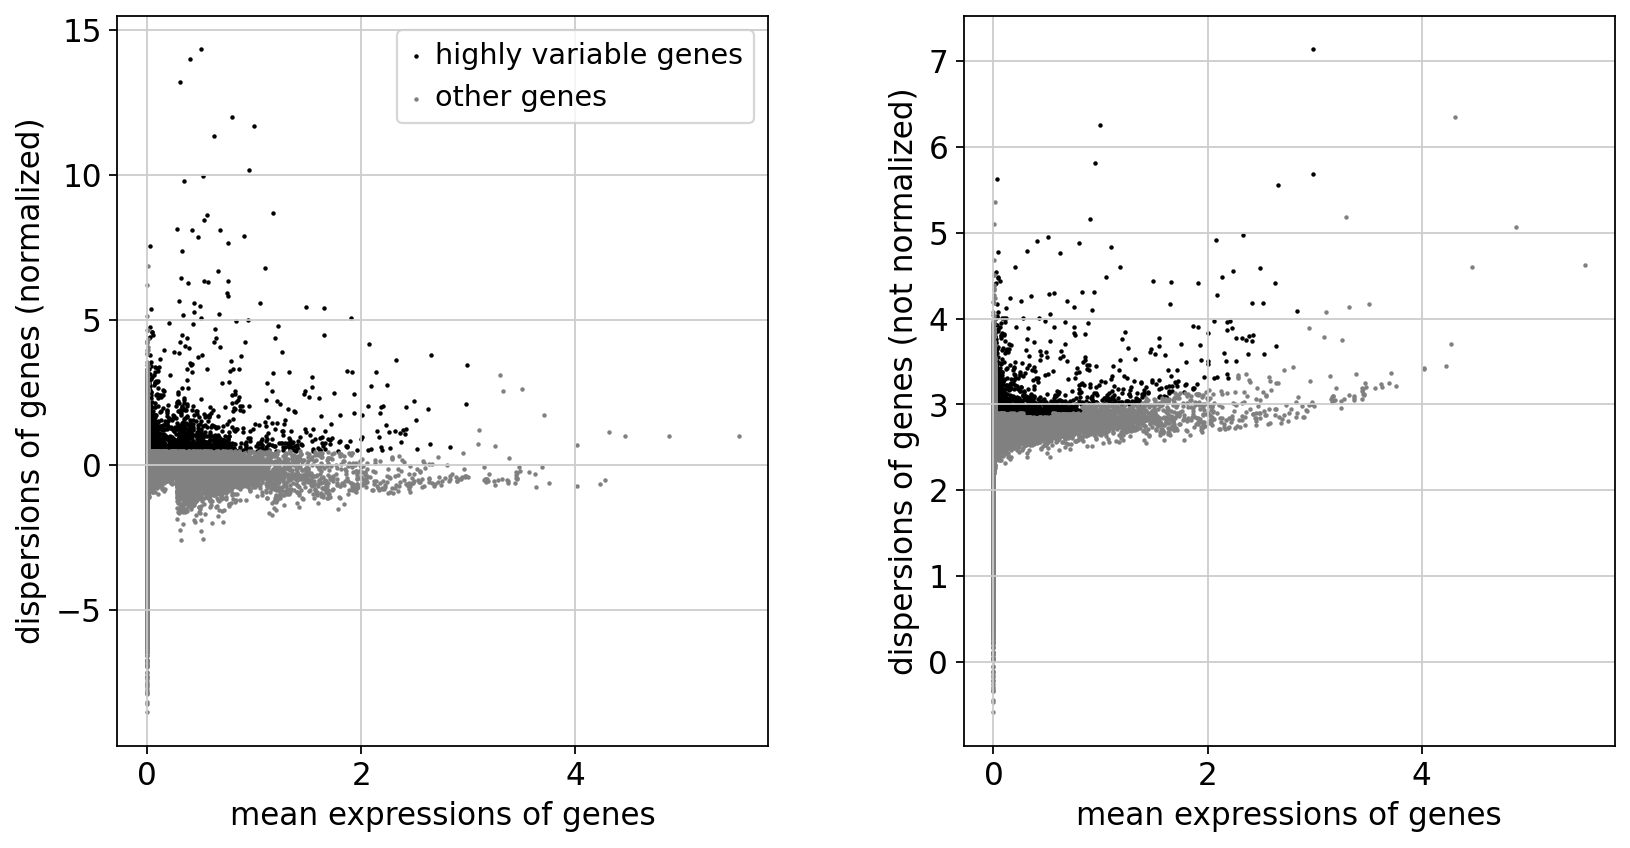

In [ ]:
sc.pp.highly_variable_genes(macaca_adata)
sc.pl.highly_variable_genes(macaca_adata)

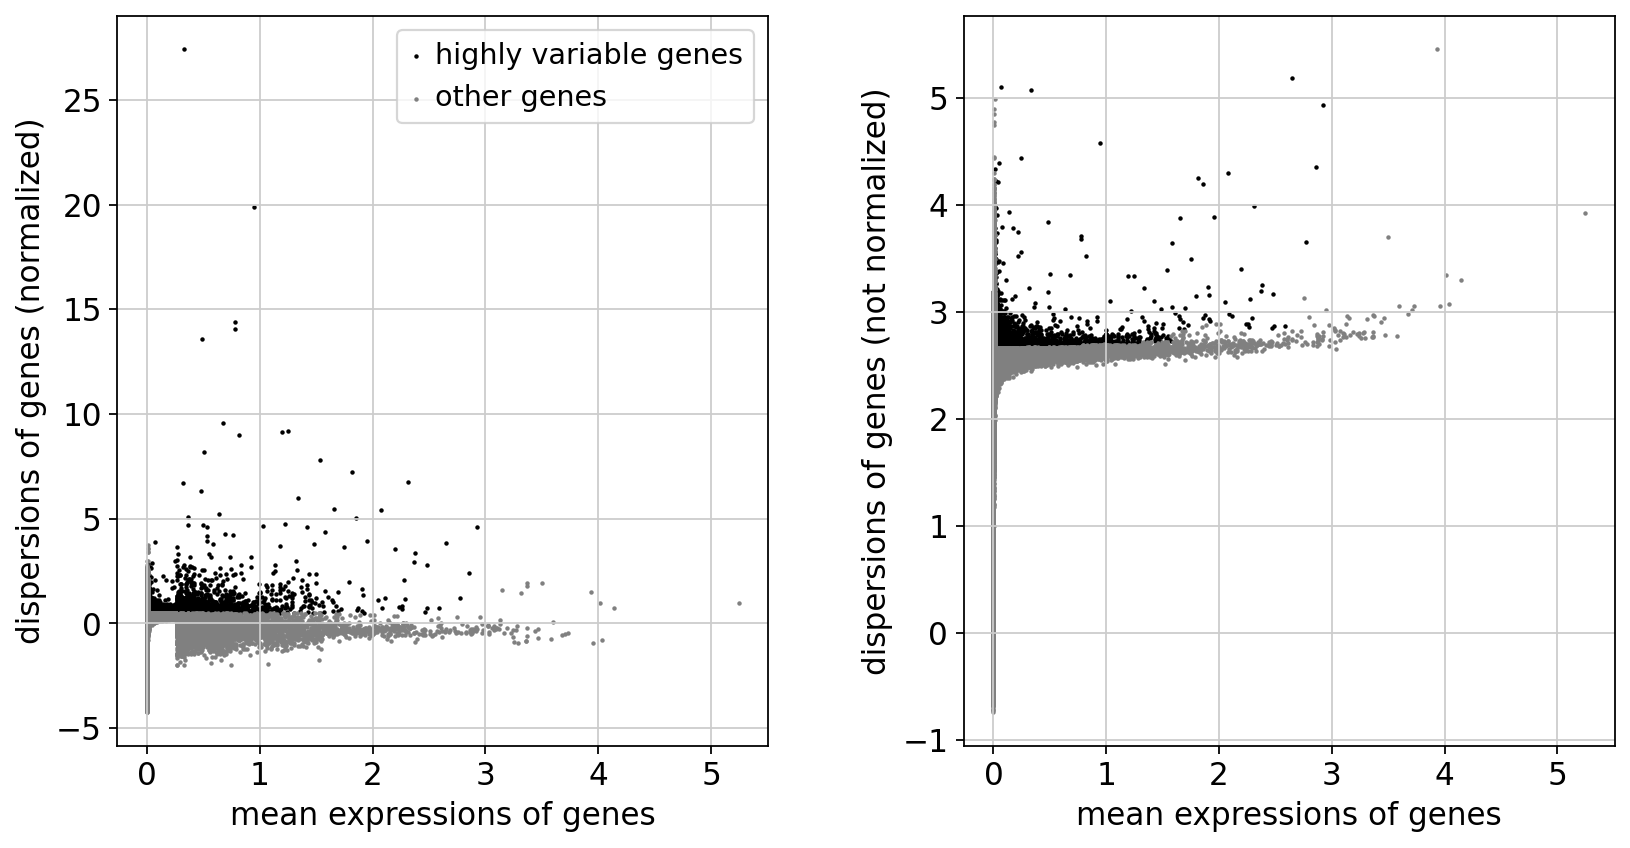

In [ ]:
sc.pp.highly_variable_genes(canis_adata)
sc.pl.highly_variable_genes(canis_adata)

### PCA


Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

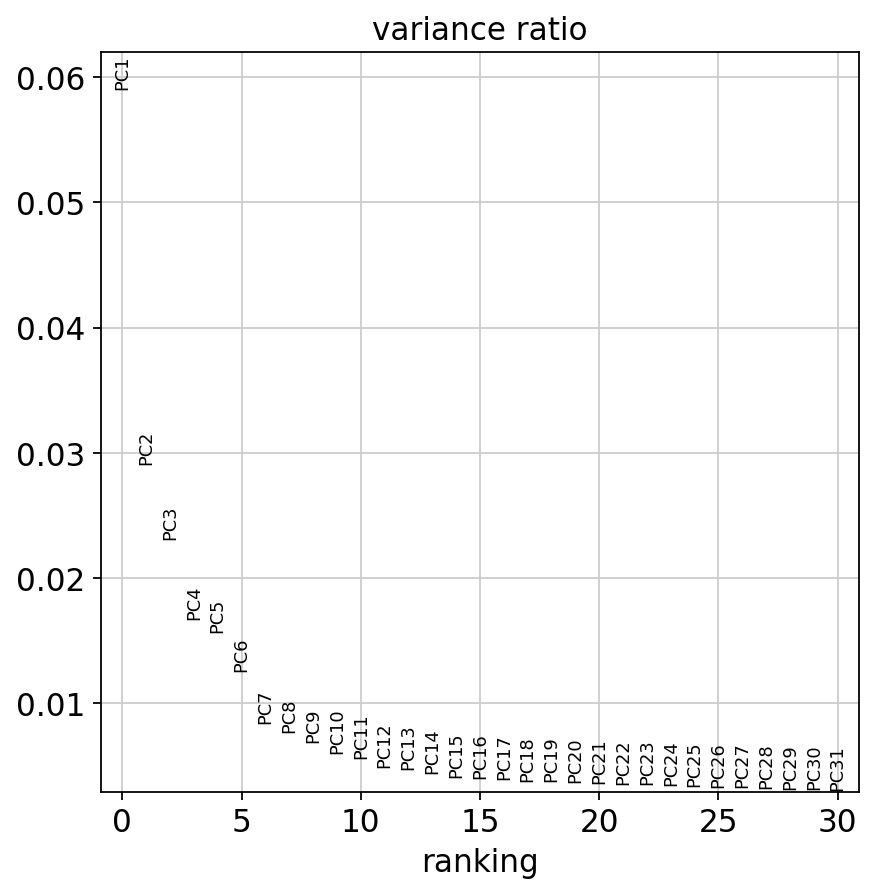

In [ ]:
# Perform PCA on just the highly variable genes
sc.tl.pca(macaca_adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(macaca_adata, log=False)

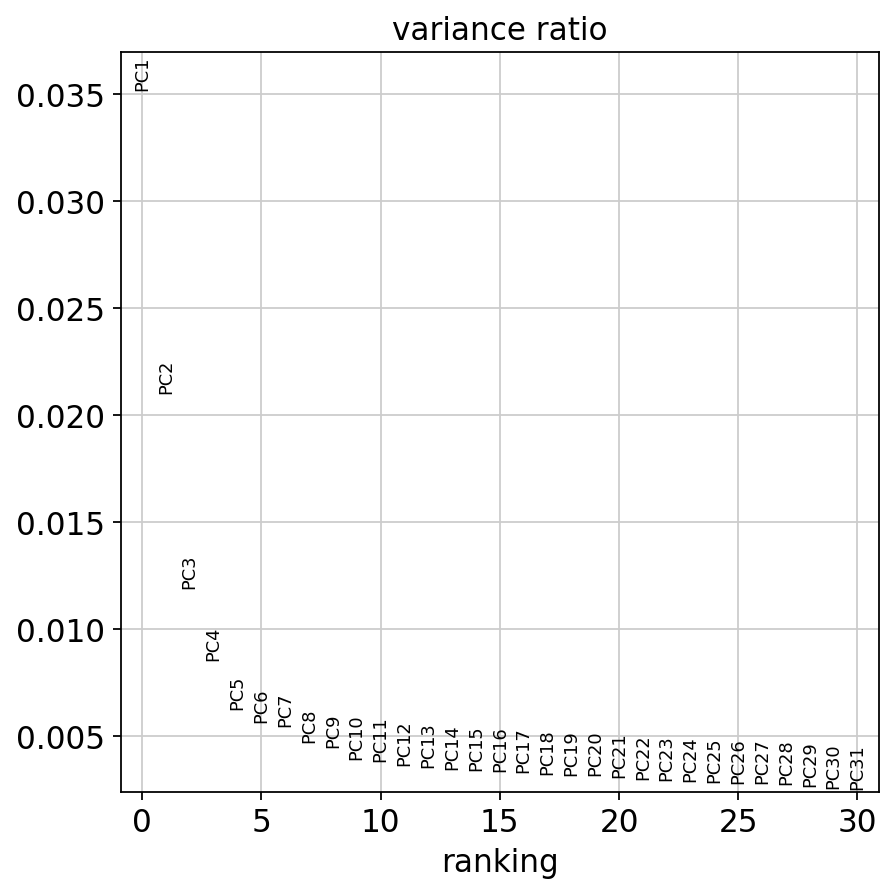

In [ ]:
# Perform PCA on just the highly variable genes
sc.tl.pca(canis_adata, use_highly_variable=True)
sc.pl.pca_variance_ratio(canis_adata, log=False)

# Leiden clustering

In [ ]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs=10

# Find nearest neighbors
sc.pp.neighbors(macaca_adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [ ]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs=10

# Find nearest neighbors
sc.pp.neighbors(canis_adata, n_neighbors=n_neighbors, n_pcs=n_pcs)

In [ ]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(macaca_adata)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [ ]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(canis_adata)

Save normalized and clustered data for all samples:

In [ ]:
macaca_adata.write("macaque_QC_norm_leiden.h5ad")
canis_adata.write("canis_QC_norm_leiden.h5ad")